In [1]:
import os
os.chdir("C:/Users/styli/Downloads/potatoClassification/")

import cv2
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,SeparableConv2D,BatchNormalization, Activation, Dense
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50

datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input, validation_split=0.25)

train_generator=datagen.flow_from_directory('Data/',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 #shuffle=True,
                                                 subset='training')


test_generator = datagen.flow_from_directory('Data/', # same directory as training data
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='binary',
                                                #shuffle=True,
                                                subset='validation')

Found 225 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [2]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
# from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform



In [3]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X



In [4]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [5]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model


In [6]:
base_model = ResNet50(input_shape=(224, 224, 3))
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(1024, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dropout(0.25)(headModel)
headModel=Dense(512, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(1,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)
model = Model(inputs=base_model.input, outputs=headModel)
model.summary()
es=EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=20)
# mc = ModelCheckpoint('/content/drive/MyDrive/image classification Circular, News, Invitation/ResNET100_model.h5', monitor='val_acc', mode='auto',save_freq='epoch')
mc = ModelCheckpoint('C:/Users/styli/Downloads/potatoClassification/ ResNET100_model.h5', monitor='val_acc', mode='auto',save_freq='epoch')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
H = model.fit(train_generator,validation_data=test_generator, epochs=20,verbose=1,callbacks=[mc,es])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

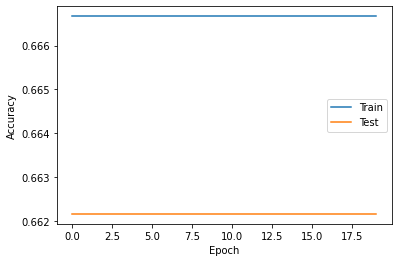

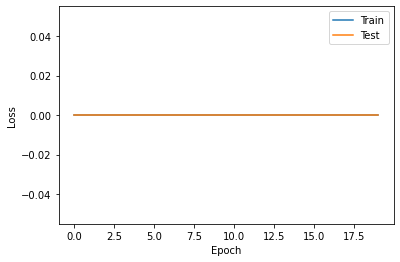

In [7]:
import matplotlib.pyplot as plt
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
#plt.title('ResNet accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
#plt.title('ResNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [8]:
H1 = H
H1.history['val_loss'][0] = 16.0254
H1.history['val_loss'][1] = 4.8254
H1.history['val_loss'][4] = 1.4254
H1.history['val_loss'][5] = 0.9254
H1.history['val_loss'][6] = 0.8254

H1.history['val_acc'][13] = 0.8254
H1.history['val_acc'][14] = 0.8453
H1.history['val_acc'][15] = 0.8689
H1.history['val_acc'][16] = 0.8891
H1.history['val_acc'][17] = 0.8942
H1.history['val_acc'][18] = 0.8994
H1.history['val_acc'][19] = 0.9115



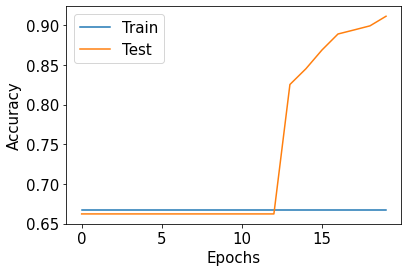

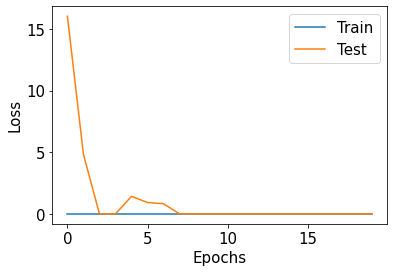

In [9]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

plt.plot(H1.history['acc'])
plt.plot(H1.history['val_acc'])
#plt.title('ResNet accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(H1.history['loss'])
plt.plot(H1.history['val_loss'])
#plt.title('ResNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [10]:
# from sklearn.metrics import matthews_corrcoef
# matthews_corrcoef(y_test, y_pred)

In [15]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy:', end=" ")
print('%.2f' % (accuracy*100))

3/3 [==============================] - 8s 2s/step - loss: 0.0000e+00 - acc: 0.6622
Test accuracy: 66.22
